In [ ]:
!pip install vnstock

## **1. Import các thư viện cần thiết**

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from vnstock import stock_historical_data
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## **2. Tải và chuẩn bị dữ liệu**

In [ ]:
# Lấy dữ liệu từ vnstock
acb = stock_historical_data("ACB", "2015-01-01", "2024-07-28", "1D")
mwg = stock_historical_data("MWG", "2015-01-01", "2024-07-28", "1D")
cmc = stock_historical_data("CMG", "2015-01-01", "2024-07-28", "1D")

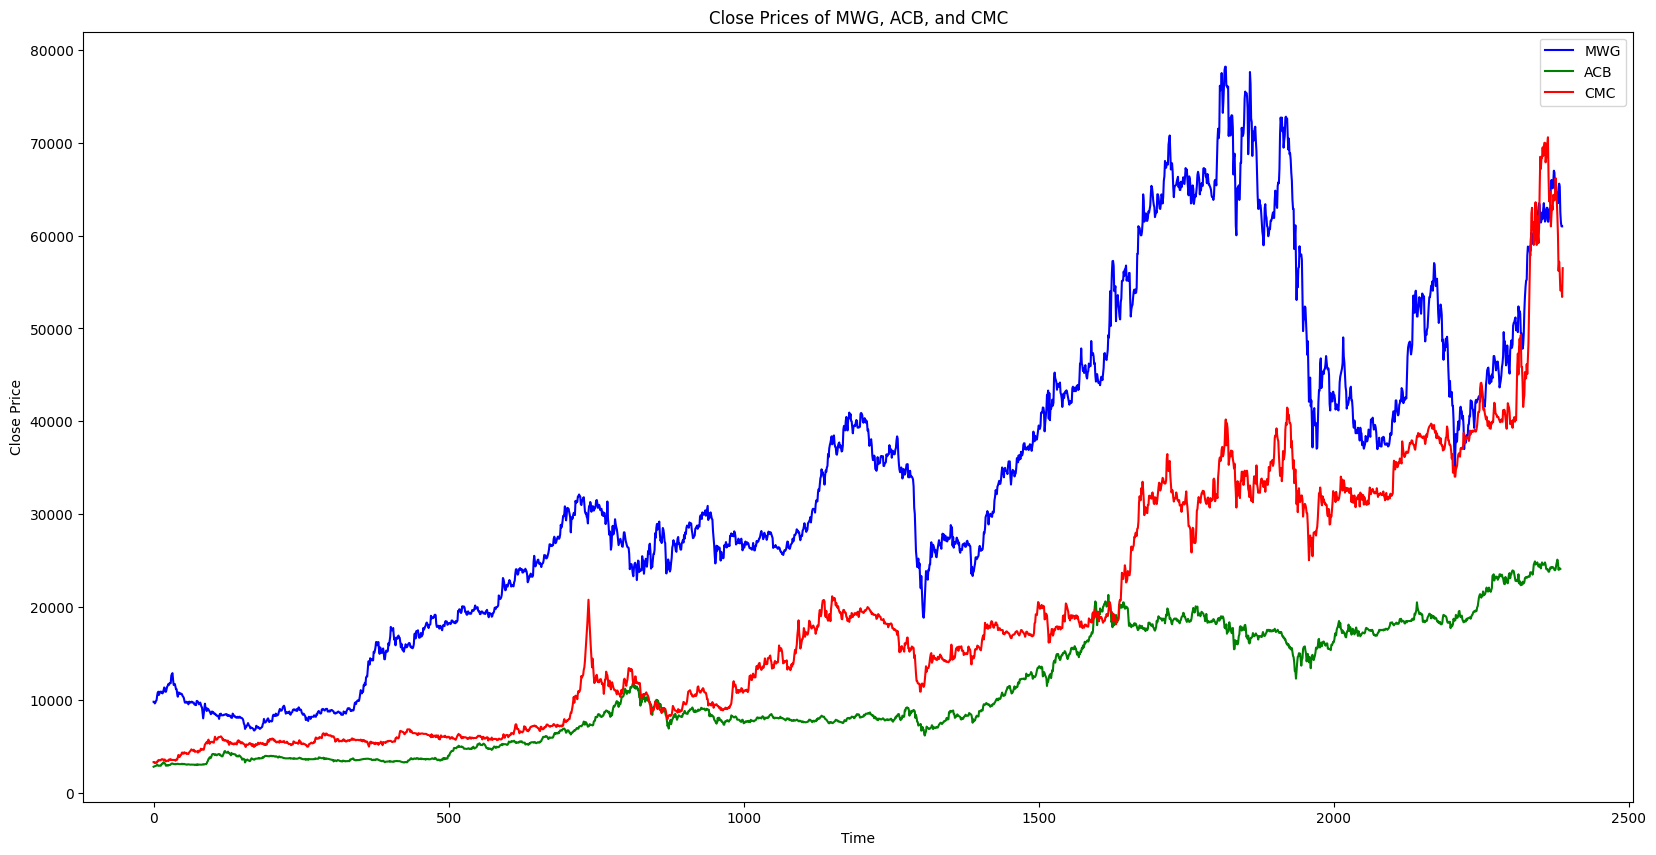

In [ ]:
# Tạo biểu đồ
plt.figure(figsize=(20, 10))

# Vẽ biểu đồ cho MWG
plt.plot(mwg.index, mwg['close'], label='MWG', color='blue')

# Vẽ biểu đồ cho ACB
plt.plot(acb.index, acb['close'], label='ACB', color='green')

# Vẽ biểu đồ cho CMC
plt.plot(cmc.index, cmc['close'], label='CMC', color='red')

# Thiết lập tiêu đề và nhãn trục
plt.title('Close Prices of MWG, ACB, and CMC')
plt.xlabel('Time')
plt.ylabel('Close Price')

# Hiển thị chú thích
plt.legend()

# Hiển thị biểu đồ
plt.show()

**Nhận xét:**
- Nhìn chung dữ liệu của cả 3 mã đều có xu hướng tăng theo thời gian
- Phương sai có vẻ cũng biến động khá mạnh

In [ ]:
# Convert int to float
acb['close'] = acb['close'].astype(float)
mwg['close'] = mwg['close'].astype(float)
cmc['close'] = cmc['close'].astype(float)

In [ ]:
def date(time_series):
    # Convert 'time' column to datetime
    time_series['time'] = pd.to_datetime(time_series['time'], format='%Y-%m-%d')
    # Set 'time' column as index
    time_series.set_index('time', inplace=True)
    time_series = time_series[['close']]
    return time_series

acb = date(acb)
mwg = date(mwg)
cmc = date(cmc)

In [ ]:
# Scale data to (0, 1)
scaler = MinMaxScaler()
mwg['close_scaled'] = scaler.fit_transform(mwg[['close']])
acb['close_scaled'] = scaler.fit_transform(acb[['close']])
cmc['close_scaled'] = scaler.fit_transform(cmc[['close']])

<ipython-input-70-d44c308062e3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mwg['close_scaled'] = scaler.fit_transform(mwg[['close']])
<ipython-input-70-d44c308062e3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acb['close_scaled'] = scaler.fit_transform(acb[['close']])
<ipython-input-70-d44c308062e3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

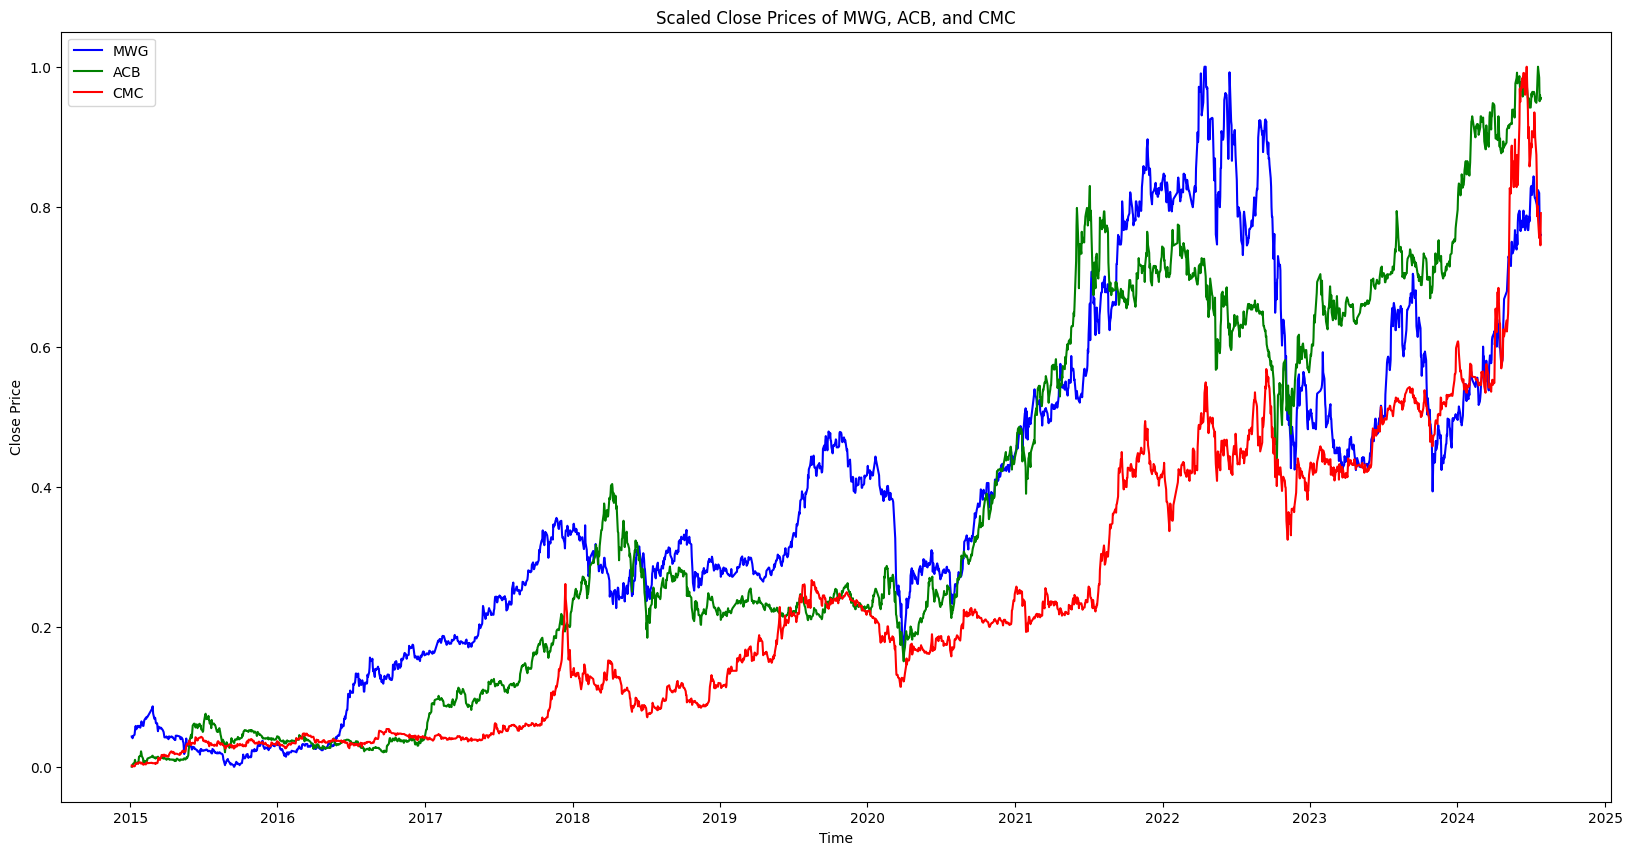

In [ ]:
# Plotting scaled close prices
plt.figure(figsize=(20, 10))
plt.plot(mwg.index, mwg['close_scaled'], label='MWG', color='blue')
plt.plot(acb.index, acb['close_scaled'], label='ACB', color='green')
plt.plot(cmc.index, cmc['close_scaled'], label='CMC', color='red')
plt.title('Scaled Close Prices of MWG, ACB, and CMC')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

## **3. Tạo tập dữ liệu huấn luyện và kiểm tra**

In [ ]:
# Split into train-test sets
def train_test_split(df):
    train = df.loc['2015-01-01':'2023-12-31']
    test = df.loc['2024-01-01':'2024-07-31']
    return train, test

In [ ]:
mwg_train, mwg_test = train_test_split(mwg)
acb_train, acb_test = train_test_split(acb)
cmc_train, cmc_test = train_test_split(cmc)

## **4. Xây dựng mô hình GRU**


In [ ]:
# Build GRU model function
def build_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [ ]:
def train_evaluate_forecast(stock_data, stock_name, learning_rate, epochs, batch_size, scaler):
    # Chuẩn bị dữ liệu
    data_train, data_test = stock_data
    X_train = data_train['close_scaled'].values.reshape(-1, 1, 1)
    y_train = data_train['close_scaled'].values
    X_test = data_test['close_scaled'].values.reshape(-1, 1, 1)
    y_test = data_test['close_scaled'].values

    # Xây dựng mô hình GRU
    model = build_gru_model((X_train.shape[1], X_train.shape[2]))

    # Huấn luyện mô hình
    history = model.fit(X_train, y_train, epochs=epochs, verbose=0, validation_split=0.2, batch_size=batch_size)

    # Dự báo trên tập huấn luyện
    train_predictions = model.predict(X_train)
    train_predictions_rescaled = scaler.inverse_transform(train_predictions)
    y_train_rescaled = scaler.inverse_transform(y_train.reshape(-1, 1))

    # Dự báo trên tập test
    test_predictions = model.predict(X_test)
    test_predictions_rescaled = scaler.inverse_transform(test_predictions)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Đánh giá và vẽ biểu đồ
    evaluate_and_plot_results(data_train.index, y_train_rescaled, train_predictions_rescaled, stock_name, 'Train')
    evaluate_and_plot_results(data_test.index, y_test_rescaled, test_predictions_rescaled, stock_name, 'Test')

    return model, history


In [ ]:
def evaluate_and_plot_results(dates, y_true, y_pred, stock_name, dataset_type):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100 if np.all(y_true != 0) else None
    r2 = r2_score(y_true, y_pred)
    print(f"--- Đánh giá cho {stock_name} trên tập {dataset_type} ---")
    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)
    print("Mean Absolute Error (MAE):", mae)
    if mape is not None:
        print("Mean Absolute Percentage Error (MAPE):", mape)
    else:
        print("MAPE không thể tính toán do có giá trị zero trong y_test.")
    print("R^2 Score:", r2)

    plot_results(dates, y_true, y_pred, stock_name, dataset_type)

def plot_results(dates, y_true, y_pred, stock_name, dataset_type):
    plt.figure(figsize=(10, 6))
    plt.plot(dates, y_true, label=f'Thực tế {dataset_type} ' + stock_name, color='blue')
    plt.plot(dates, y_pred, label=f'Dự đoán {dataset_type} ' + stock_name, color='red')
    plt.gcf().autofmt_xdate()
    plt.title(f'GRU dự báo giá chứng khoán cho {stock_name} trên tập ({dataset_type})')
    plt.xlabel('Ngày')
    plt.ylabel('Giá')
    plt.legend()
    plt.show()

## **5. Huấn luyện mô hình GRU**

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
--- Đánh giá cho MWG trên tập Train ---
Mean Squared Error (MSE): 975493.8728931443
Root Mean Squared Error (RMSE): 987.6709335062687
Mean Absolute Error (MAE): 981.4257837224518
Mean Absolute Percentage Error (MAPE): 6.862414650156931
R^2 Score: 0.9964219149142111


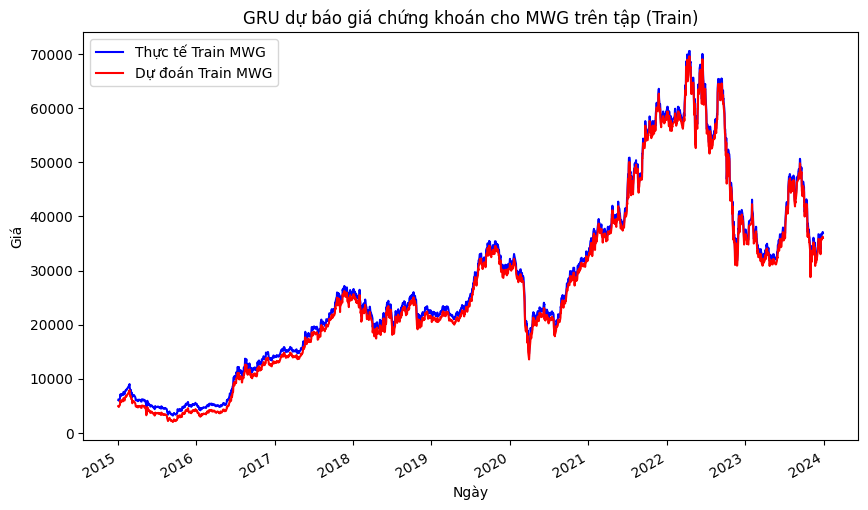

--- Đánh giá cho MWG trên tập Test ---
Mean Squared Error (MSE): 716524.7672918686
Root Mean Squared Error (RMSE): 846.4778598946747
Mean Absolute Error (MAE): 846.3935046047691
Mean Absolute Percentage Error (MAPE): 1.8331772218890257
R^2 Score: 0.9873966311655324


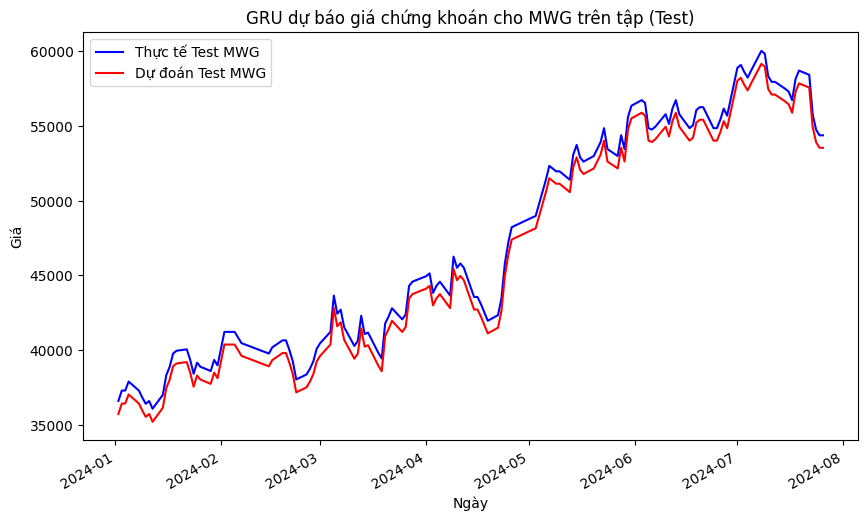

In [ ]:
model_mwg, history_mwg = train_evaluate_forecast((mwg_train, mwg_test), "MWG", 0.01, 20, 32, scaler)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
--- Đánh giá cho ACB trên tập Train ---
Mean Squared Error (MSE): 760533.228576374
Root Mean Squared Error (RMSE): 872.0855626464493
Mean Absolute Error (MAE): 840.6352996108847
Mean Absolute Percentage Error (MAPE): 5.166465456399942
R^2 Score: 0.9974130111309287


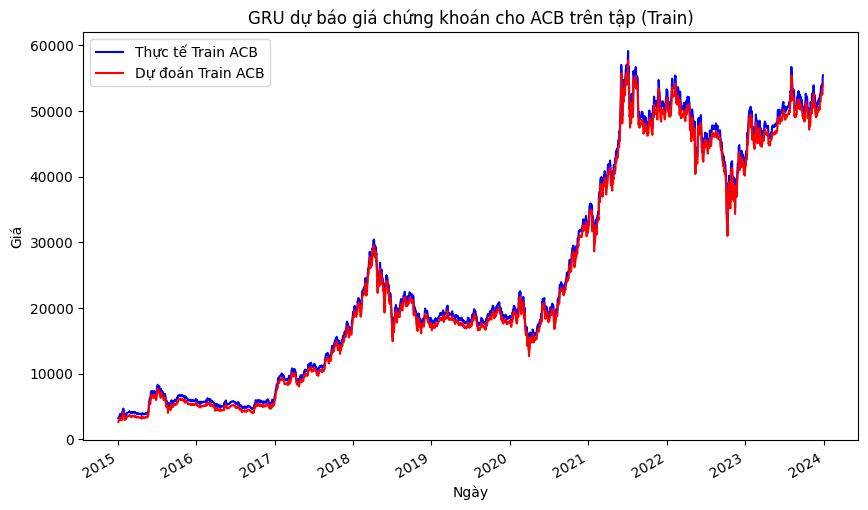

--- Đánh giá cho ACB trên tập Test ---
Mean Squared Error (MSE): 2423310.1171250176
Root Mean Squared Error (RMSE): 1556.6984669887156
Mean Absolute Error (MAE): 1554.0058664035946
Mean Absolute Percentage Error (MAPE): 2.3864928883042933
R^2 Score: 0.7551470272530602


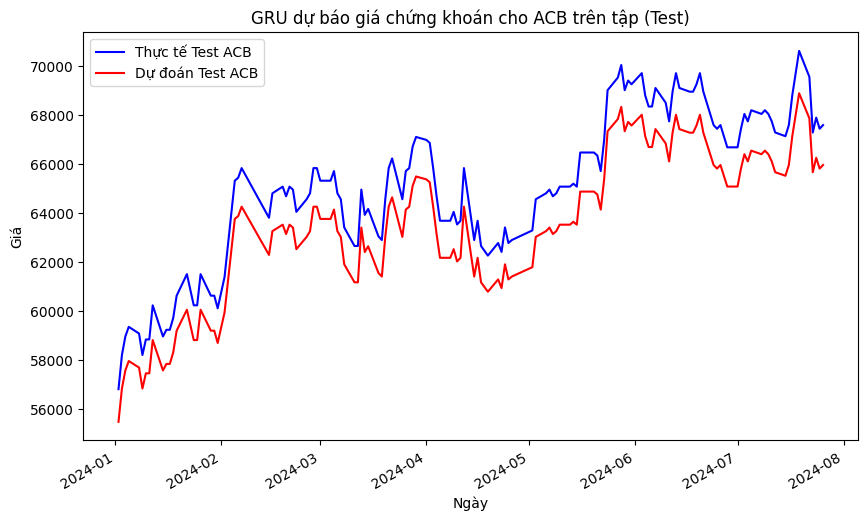

In [ ]:
model_acb, history_acb = train_evaluate_forecast((acb_train, acb_test), "ACB", 0.01, 20, 32, scaler)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
--- Đánh giá cho CMC trên tập Train ---
Mean Squared Error (MSE): 11715.038954300393
Root Mean Squared Error (RMSE): 108.23603352996817
Mean Absolute Error (MAE): 105.21967380467675
Mean Absolute Percentage Error (MAPE): 0.8971231988048609
R^2 Score: 0.9999060735857951


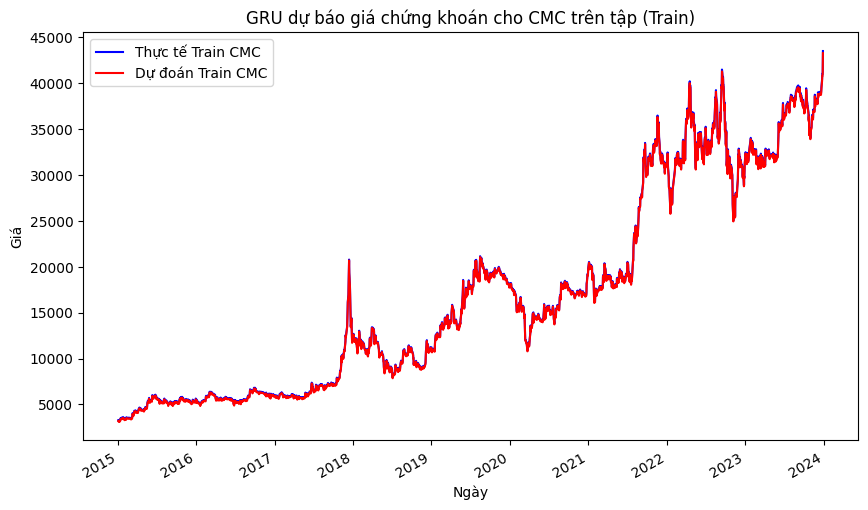

--- Đánh giá cho CMC trên tập Test ---
Mean Squared Error (MSE): 218619.54805352396
Root Mean Squared Error (RMSE): 467.56769355198605
Mean Absolute Error (MAE): 399.1721261160717
Mean Absolute Percentage Error (MAPE): 0.7290055330232237
R^2 Score: 0.9981529664822201


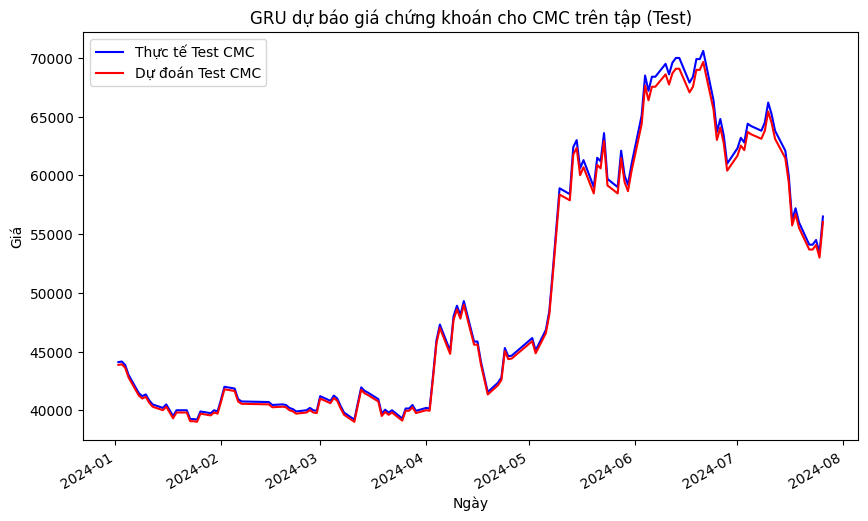

In [ ]:
model_cmc, history_cmc = train_evaluate_forecast((cmc_train, cmc_test), "CMC", 0.01, 20, 32, scaler)

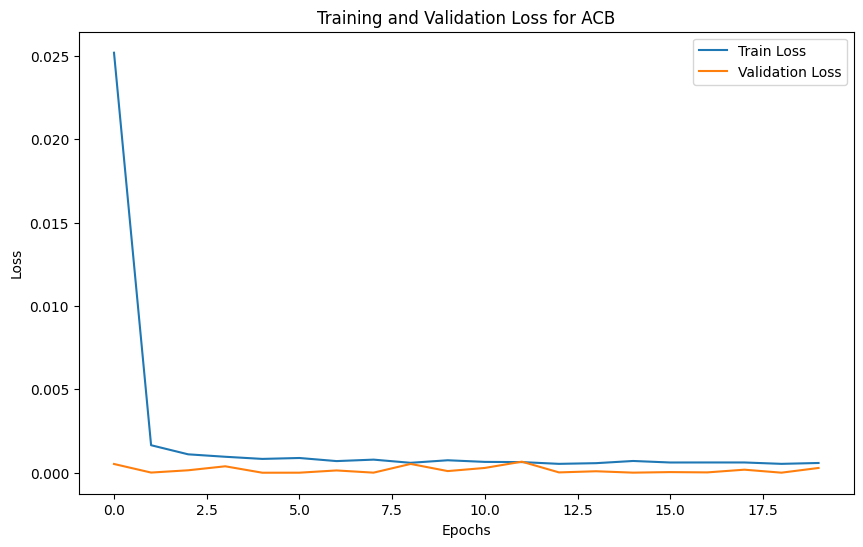

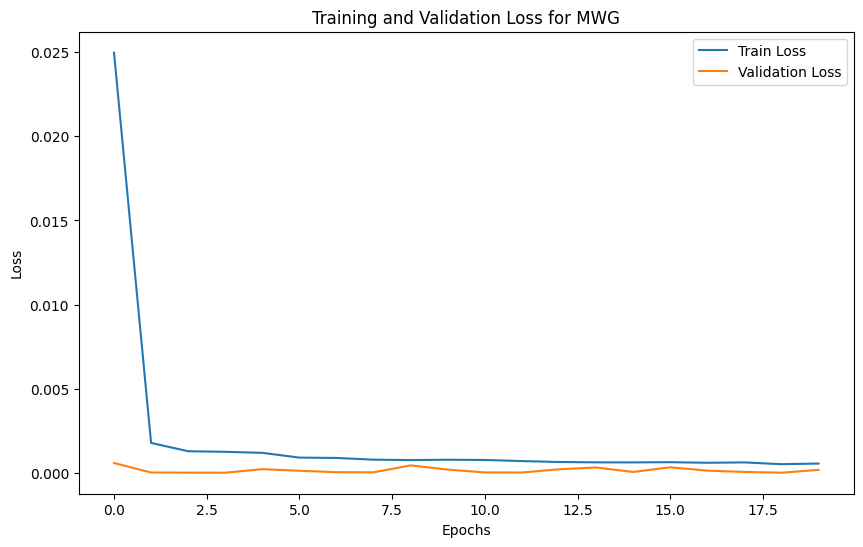

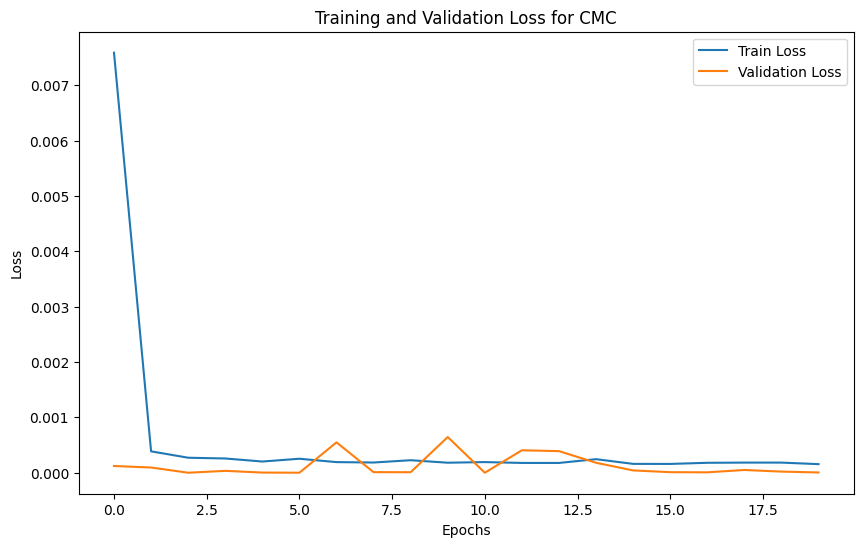

In [ ]:
def plot_training_history(history, title):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.show()

plot_training_history(history_acb, 'Training and Validation Loss for ACB')
plot_training_history(history_mwg, 'Training and Validation Loss for MWG')
plot_training_history(history_cmc, 'Training and Validation Loss for CMC')

## **7. GRU kết hợp kỹ thuật Sliding Window**

In [ ]:
def train_evaluate_forecast_sliding(stock_data, stock_name, n_steps, learning_rate, epochs, batch_size, scaler):
    def create_sequences(data, n_steps):
        X, y = [], []
        for i in range(n_steps, len(data)):
            X.append(data[i-n_steps:i])
            y.append(data[i])
        return np.array(X), np.array(y)

    # Chuẩn bị dữ liệu
    data_train, data_test = stock_data
    X_train, y_train = create_sequences(data_train['close_scaled'].values, n_steps)
    X_test, y_test = create_sequences(data_test['close_scaled'].values, n_steps)

    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Xây dựng mô hình GRU
    model = build_gru_model((X_train.shape[1], X_train.shape[2]))

    # Huấn luyện mô hình
    history = model.fit(X_train, y_train, epochs=epochs, verbose=0, validation_split=0.2, batch_size=batch_size)

    # Dự báo trên tập huấn luyện
    train_predictions = model.predict(X_train)
    train_predictions_rescaled = scaler.inverse_transform(train_predictions)
    y_train_rescaled = scaler.inverse_transform(y_train.reshape(-1, 1))

    # Dự báo trên tập test
    test_predictions = model.predict(X_test)
    test_predictions_rescaled = scaler.inverse_transform(test_predictions)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Đánh giá và vẽ biểu đồ
    evaluate_and_plot_results(data_train.index[n_steps:], y_train_rescaled, train_predictions_rescaled, stock_name, 'Train')
    evaluate_and_plot_results(data_test.index[n_steps:], y_test_rescaled, test_predictions_rescaled, stock_name, 'Test')

    return model, history


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
--- Đánh giá cho MWG trên tập Train ---
Mean Squared Error (MSE): 2049075.5441925705
Root Mean Squared Error (RMSE): 1431.4592359521002
Mean Absolute Error (MAE): 1157.438262733449
Mean Absolute Percentage Error (MAPE): 8.379998111778688
R^2 Score: 0.9924718695700353


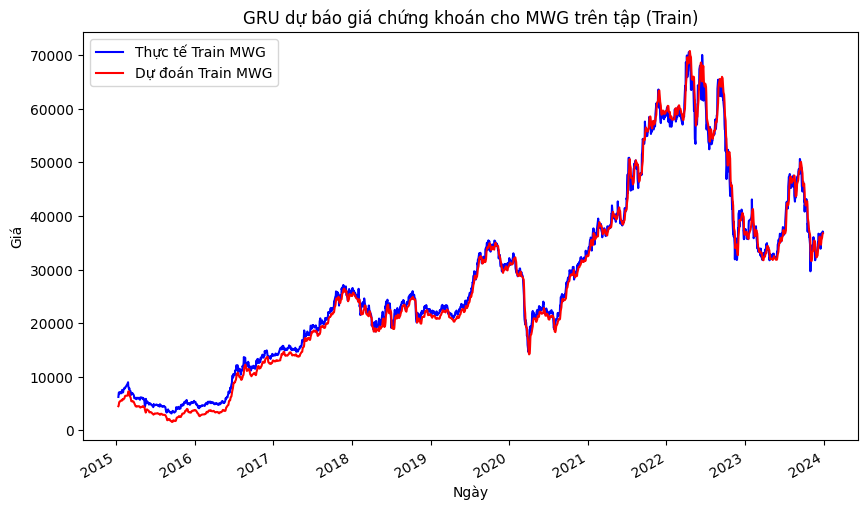

--- Đánh giá cho MWG trên tập Test ---
Mean Squared Error (MSE): 1967698.653884684
Root Mean Squared Error (RMSE): 1402.746824585493
Mean Absolute Error (MAE): 1123.908460785742
Mean Absolute Percentage Error (MAPE): 2.392865972276892
R^2 Score: 0.9642196730496881


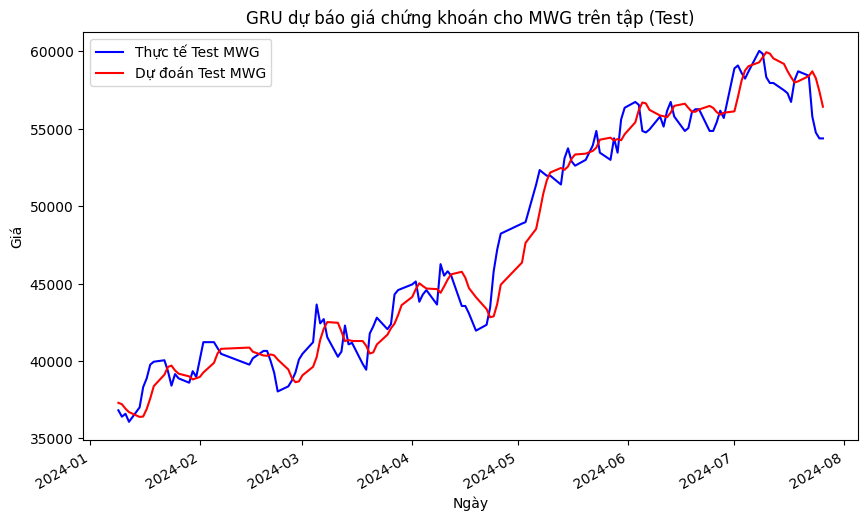

In [ ]:
# Assuming mwg, acb, cmc are preprocessed datasets
model_mwg, history_mwg = train_evaluate_forecast_sliding((mwg_train, mwg_test), "MWG", 5, 0.01, 20, 32, scaler)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
--- Đánh giá cho ACB trên tập Train ---
Mean Squared Error (MSE): 1261190.6842318345
Root Mean Squared Error (RMSE): 1123.0274637032855
Mean Absolute Error (MAE): 917.652323350489
Mean Absolute Percentage Error (MAPE): 7.344240429916855
R^2 Score: 0.9956979166467487


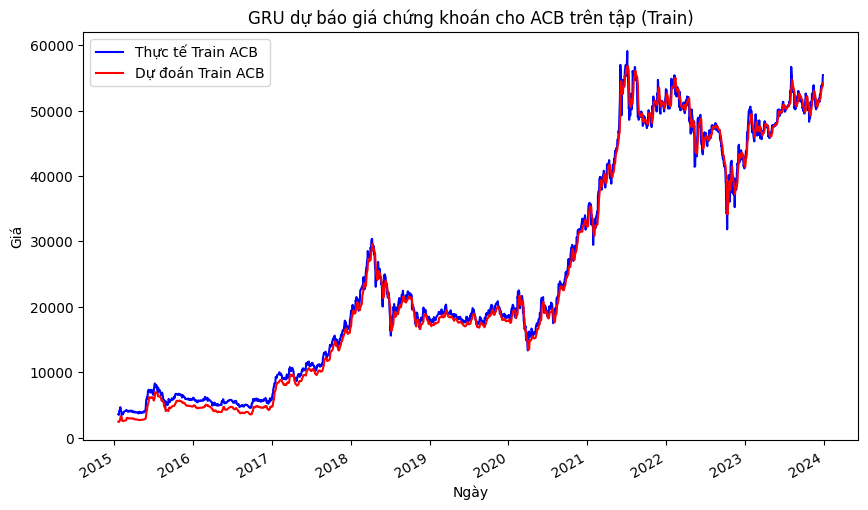

--- Đánh giá cho ACB trên tập Test ---
Mean Squared Error (MSE): 1234709.52515254
Root Mean Squared Error (RMSE): 1111.1748400465788
Mean Absolute Error (MAE): 839.1987219129259
Mean Absolute Percentage Error (MAPE): 1.2760836354736373
R^2 Score: 0.8305151492681466


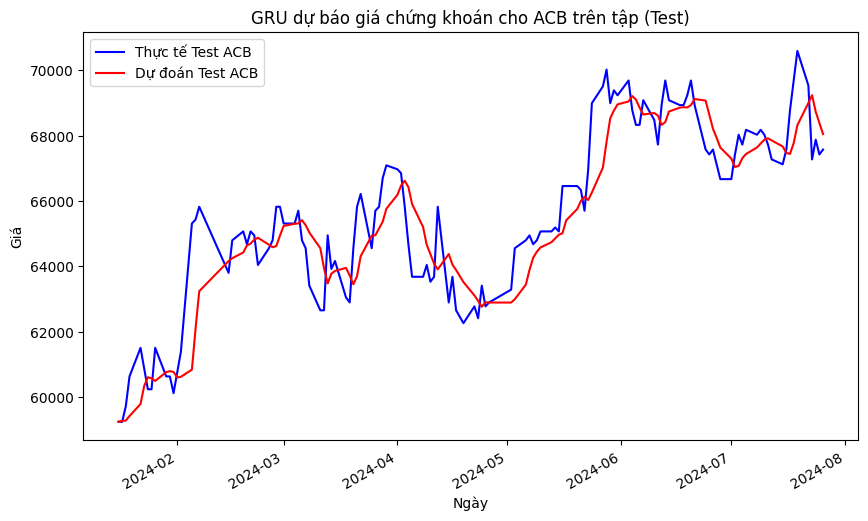

In [ ]:
model_acb, history_acb = train_evaluate_forecast_sliding((acb_train, acb_test), "ACB", 10, 0.01, 20, 32, scaler)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
--- Đánh giá cho CMC trên tập Train ---
Mean Squared Error (MSE): 1008513.0582699324
Root Mean Squared Error (RMSE): 1004.2475084708611
Mean Absolute Error (MAE): 719.5200078639666
Mean Absolute Percentage Error (MAPE): 4.766895907767748
R^2 Score: 0.9918951977701388


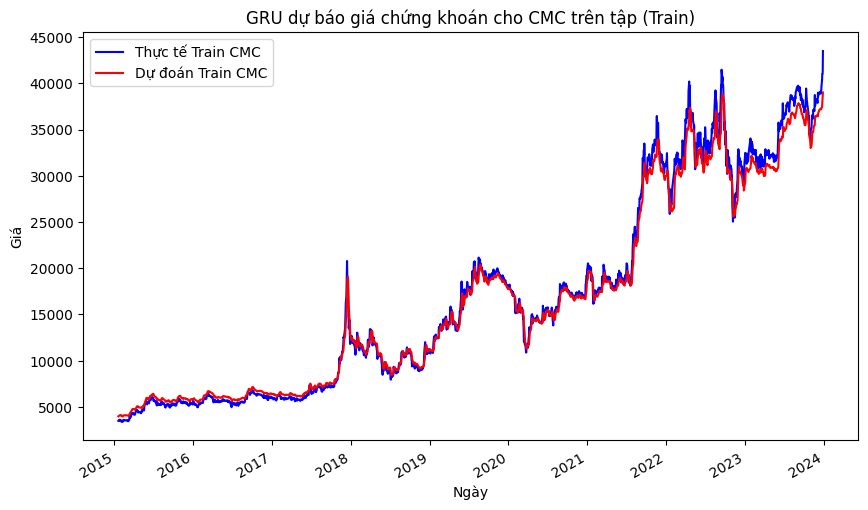

--- Đánh giá cho CMC trên tập Test ---
Mean Squared Error (MSE): 13996262.064587876
Root Mean Squared Error (RMSE): 3741.157850798049
Mean Absolute Error (MAE): 3056.5241586538464
Mean Absolute Percentage Error (MAPE): 5.7744301624382555
R^2 Score: 0.8847168925046944


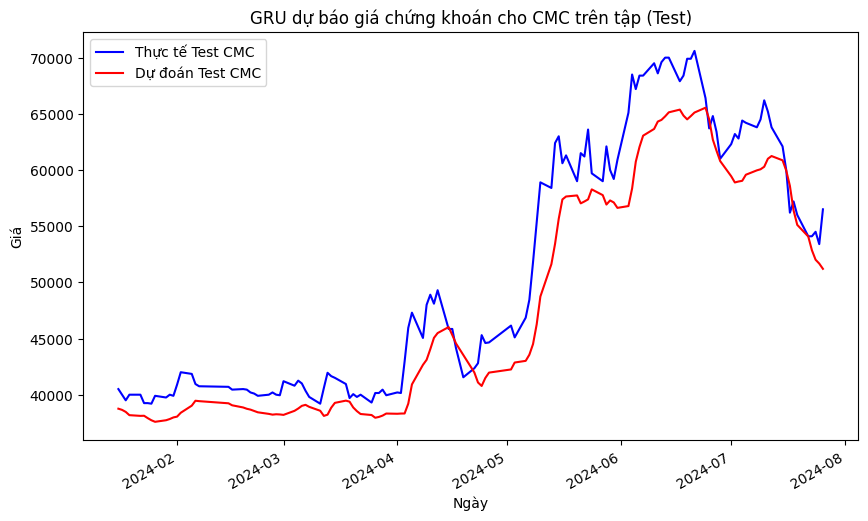

In [ ]:
model_cmc, history_cmc = train_evaluate_forecast_sliding((cmc_train, cmc_test), "CMC", 10, 0.01, 20, 32, scaler)

## **8. GRU kết hợp kỹ thuật Expanding Window**

In [ ]:
def expanding_window_gru(stock_data, stock_name, learning_rate, epochs, batch_size, scaler):
    data_train, data_test = stock_data
    X_train = data_train['close_scaled'].values.reshape(-1, 1, 1)
    y_train = data_train['close_scaled'].values
    X_test = data_test['close_scaled'].values.reshape(-1, 1, 1)
    y_test = data_test['close_scaled'].values

    model = build_gru_model((X_train.shape[1], X_train.shape[2]))
    predictions = []

    for i in range(len(y_test)):
        model.fit(X_train, y_train, epochs=1, batch_size=batch_size, verbose=0)
        pred = model.predict(X_test[i].reshape(1, -1, 1))
        predictions.append(pred[0][0])
        X_train = np.append(X_train, X_test[i]).reshape(-1, X_train.shape[1], 1)
        y_train = np.append(y_train, y_test[i])

    predictions = np.array(predictions).reshape(-1, 1)
    predictions_rescaled = scaler.inverse_transform(predictions)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
    r2 = r2_score(y_test_rescaled, predictions_rescaled)
    mape = np.mean(np.abs((y_test_rescaled - predictions_rescaled) / y_test_rescaled)) * 100

    print(f'--- {stock_name} Model Performance - Expanding Window GRU ---')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'MAE: {mae}')
    print(f'R-squared: {r2}')
    print(f'MAPE: {mape}%')

    plt.figure(figsize=(10, 6))
    plt.plot(y_test_rescaled, color='blue', label='Actual')
    plt.plot(predictions_rescaled, color='red', label='Predicted')
    plt.title(f'Actual vs Predicted Prices for {stock_name} with Expanding Window GRU')
    plt.legend()
    plt.show()

ACB Model Performance - Expanding Window GRU:


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━

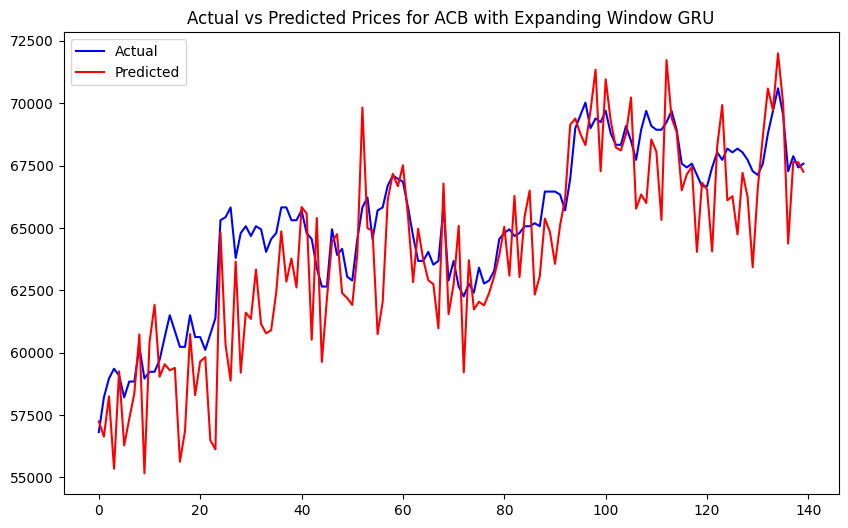

In [ ]:
# Assuming mwg, acb, cmc are preprocessed datasets
print("ACB Model Performance - Expanding Window GRU:")
expanding_window_gru((acb_train, acb_test), "ACB", 0.01, 1, 1, scaler)

MWG Model Performance - Expanding Window GRU:


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

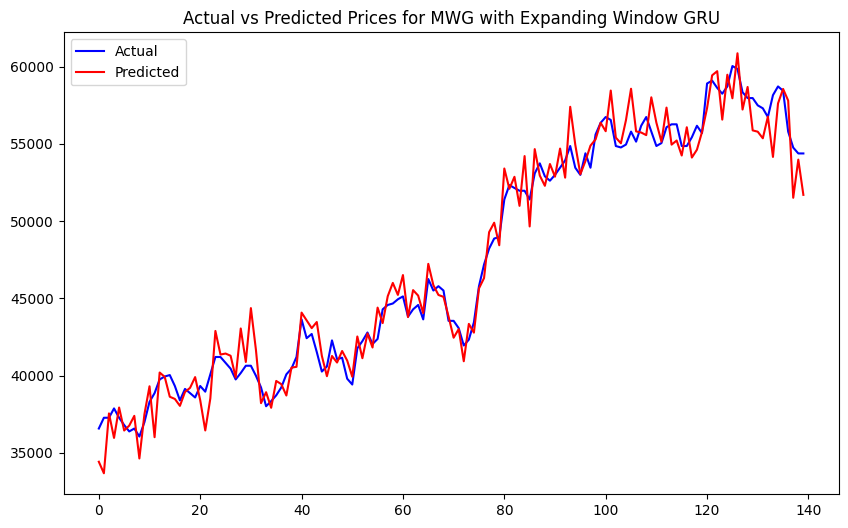

In [ ]:
print("MWG Model Performance - Expanding Window GRU:")
expanding_window_gru((mwg_train, mwg_test), "MWG", 0.01, 1, 1, scaler)

CMC Model Performance - Expanding Window GRU:


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━

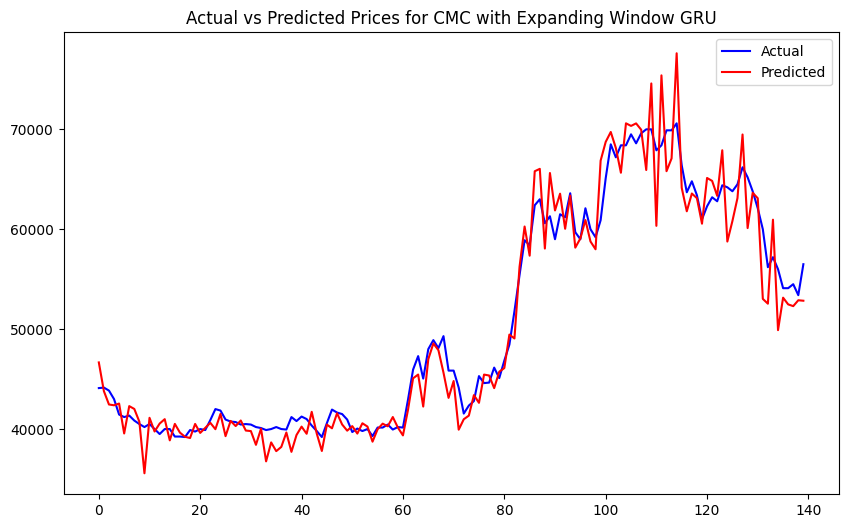

In [ ]:
print("CMC Model Performance - Expanding Window GRU:")
expanding_window_gru((cmc_train, cmc_test), "CMC", 0.01, 1, 1, scaler)